In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.tests.test3 import Test
from bitalg.visualizer.main import Visualizer

# Triangulacja wielokątów monotonicznych - problem monitorowania galerii


## Przydatne funkcje


In [27]:
polygon_example_1 = [(5, 5), (3, 4), (6, 3), (4, 2), (6, 0), (7, 1), (8, 4)]
polygon_example_2 = [(2, 0), (5, 1), (6, 0), (8, 3), (7, 2), (8, 7), (6, 9), (5, 8),
                     (2, 9), (1, 7), (2, 4), (4, 5), (3, 6), (5, 7), (5.5, 3), (2, 2), (1, 3), (0, 1)]
polygon_example_colors = [1, 3, 1, 0, 2, 4, 0, 2, 0, 4, 1, 4, 4, 3, 4, 2, 0, 4]
polygon_example_tri = [(polygon_example_1[0], polygon_example_1[2]),
                       (polygon_example_1[2], polygon_example_1[5]),
                       (polygon_example_1[2], polygon_example_1[6]),
                       #   (polygon_example_1[6], polygon_example_1[3]),
                       (polygon_example_1[2], polygon_example_1[4]),
                       ]

In [28]:
def draw_polygon(polygon):
    vis = Visualizer()
    points = polygon
    vis.add_polygon(polygon, fill=False)
    vis.show()

In [29]:
def draw_polygon_colors(polygon, colors):
    points_start = []
    points_end = []
    points_connect = []
    points_divide = []
    points_regular = []
    for i in range(len(polygon)):
        if colors[i] == 0:
            points_start.append(polygon[i])
        elif colors[i] == 1:
            points_end.append(polygon[i])
        elif colors[i] == 2:
            points_connect.append(polygon[i])
        elif colors[i] == 3:
            points_divide.append(polygon[i])
        elif colors[i] == 4:
            points_regular.append(polygon[i])

    vis = Visualizer()
    colors_start = ['green']
    color_end = ['red']
    color_connect = ['blue']
    color_divide = ['cyan']
    color_regular = ['#3B240B']
    vis.add_polygon(polygon, fill=False)
    vis.add_point(points_start, color=colors_start)
    vis.add_point(points_end, color=color_end)
    vis.add_point(points_connect, color=color_connect)
    vis.add_point(points_divide, color=color_divide)
    vis.add_point(points_regular, color=color_regular)
    vis.show()

In [30]:
def draw_polygon_tri(polygon, tri):

    vis = Visualizer()
    points = polygon
    tri_line_segments = tri
    vis.add_polygon(points, fill=False)
    vis.add_point(points)
    vis.add_line_segment(tri_line_segments, color='red')
    vis.show()

## Wprowadzenie
Celem ćwiczenia jest:
- sprawdzanie $y$-monotoniczności
- podział wierchołków na kategorie
- triangulacja wielokąta monotonicznego

### Przykładowy wielokąt $y$-monotoniczny

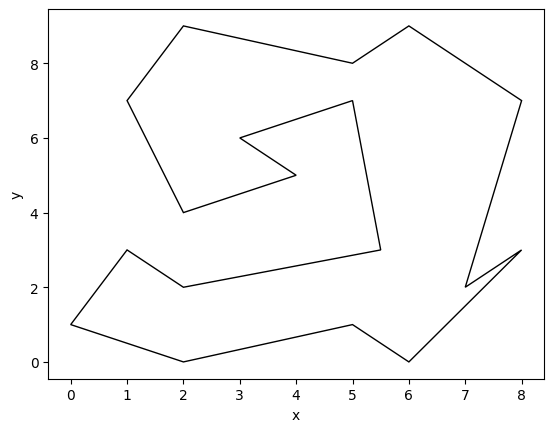

In [31]:
draw_polygon(polygon_example_2)

Do tego celu wygeneruj wielokąt.

In [32]:
polygon = polygon_example_2

## Czy wielokąt jest $y$-monotoniczny?

Wielokąt jest monotoniczny, gdy jego wierzchołki mogą być ułożone w taki sposób, że jedna z jego współrzędnych (na przykład współrzędna $x$ lub $y$, w zależności od układu współrzędnych) zawsze rośnie lub maleje wzdłuż kolejnych wierzchołków. Innymi słowy, dla każdej pary wierzchołków wielokąta (oprócz wierzchołka startowego i końcowego), jeden z punktów ma większą (lub mniejszą) wartość danej współrzędnej niż drugi punkt.

W praktyce, wielokąt monotoniczny może być łatwiej sortowany lub przetwarzany w pewnych algorytmach geometrycznych, ponieważ istnieje pewna kolejność, w jakiej wierzchołki pojawiają się wzdłuż danej osi (np. osi $x$ lub $y$). Monotoniczność może ułatwić znajdowanie przecięć linii w takim wielokącie lub wykonywanie innych operacji geometrycznych. W tym zadaniu interesuje nas monotoniczność wielokąta wzdłuż osi $y$.

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```is_y_monotonic```. Pamiętaj, aby sprawozdanie zawierało krótki opis działania tej funkcji.

In [33]:
def find_index_of_highest(points, reversed=False, eps=0):
    p0_idx = 0
    p0 = points[0]
    def compare(x, y): return x > y if reversed else x < y
    for i in range(1, len(points)):
        if compare(p0[1], points[i][1]) or (abs(p0[1] - points[i][1]) <= eps and p0[0] > points[i][0]):
            p0 = points[i]
            p0_idx = i
    return p0_idx

In [34]:
def prevNbour(i, n): return i-1 if i > 0 else n-1

In [35]:
def nextNbour(i, n): return (i+1) % n

In [36]:
def is_y_monotonic(polygon):
    """
    Funkcja określa czy podana figura jest y-monotoniczna.
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: wartość bool - true, jeśli wielokąt jest monotoniczny i false jeśli nie jest
    """
    n = len(polygon)

    if n < 4:
        return True
    pTop = find_index_of_highest(polygon)
    pBottom = find_index_of_highest(polygon, reversed=True)
    i = nextNbour(pTop, n)
    prev_y = polygon[pTop][1]
    while i != pBottom:
        curr_y = polygon[i][1]
        if curr_y > prev_y:
            return False
        prev_y = curr_y
        i = nextNbour(i, n)

    i = prevNbour(pTop, n)
    prev_y = polygon[pTop][1]
    while i != pBottom:
        curr_y = polygon[i][1]
        if curr_y > prev_y:
            return False
        prev_y = curr_y
        i = prevNbour(i, n)

    return True

Przeprowadź test poprawności powyższej funkcji.

In [37]:
Test().runtest(1, is_y_monotonic)

Lab 3, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
Result: 10/10
Time: 0.002s


Sprawdź monotoniczność swojego wielokątu.

In [38]:
print(is_y_monotonic(polygon))

False


***

# Podział wierzchołków na kategorie

Wierzchołki naszego wielokąta możemy podzielić na parę kategorii:
- początkowe, gdy obaj jego sąsiedzi leżą poniżej i kąt wewnętrzny ma mniej niż 180 stopni. To wierzchołki, w których wielokąt zaczyna się monotoniczny spadek 
- końcowe, gdy obaj jego sąsiedzi leżą powyżej i kąt wewnętrzny ma mniej niż 180 stopni. To wierzchołki, w których monotoniczność wielokąta się zmienia, czyli na przykład zaczyna się monotoniczny wzrost, jeśli wcześniej był spadek, lub na odwrót.

Wierzchołki startowe i końcowe są ważne w kontekście algorytmów przetwarzania wielokątów monotonicznych, takich jak algorytmy dziel i zwyciężaj oraz triangulacji. 
- dzielący, gdy obaj jego sąsiedzi leżą poniżej i kąt wewnęntrzny ma więcej niż 180 stopni. To wierzchołki, które wyznaczają przekątne (linie łączące), tworzące trójkąty podczas triangulacji.
- łączący, gdy obaj jego sąsiedzi leżą powyżej i kąt wewnęntrzny ma więcej niż 180 stopni. To wierzchołki, które są połączone liniami (przekątnymi) wewnątrz wielokąta, tworząc trójkąty.

Wierzchołki łączące i dzielące odgrywają kluczową rolę w procesie triangulacji wielokątów, pozwalając na podział figury na trójkąty w sposób bezkolizyjny. 
- prawdiłowy, pozostałe przypadki, jeden sąsiad powyżej drugi poniżej


### Przykładowy wielokąt z pokolorowanymi wierzchołkami.

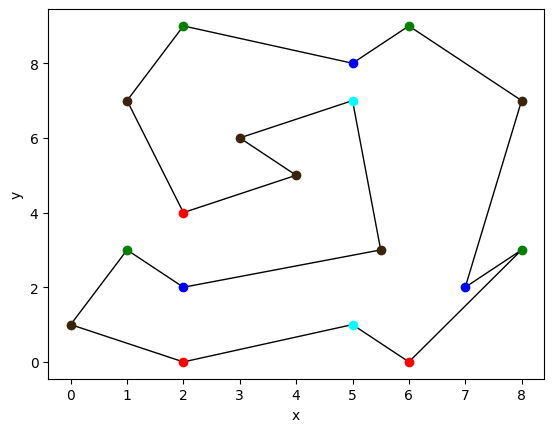

In [39]:
draw_polygon_colors(polygon_example_2, polygon_example_colors)

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```color_vertex``` .

In [40]:
def mat_det(a, b, c):
    ax, ay = a
    bx, by = b
    cx, cy = c
    return (bx-ax)*(cy-by)-(by-ay)*(cx-bx)

In [41]:
def orient(a, b, c, eps=0):
    """
    Celem funkcji jest stworzenie porządku dla punktów. Sprawdza czy mniejszy kąt względem osi OX tworzy prosta ab czy ac
    """
    det = mat_det(a, b, c)
    if abs(det) <= eps:
        return 0
    if det < eps:
        return 1
    return -1

In [42]:
# Labels consts
START = "start"
END = "end"
CONNECT = "connect"
DIVIDE = "divide"
REGULAR = "regular"
COLORS_LABELS = {START: 0, END: 1, CONNECT: 2, DIVIDE: 3, REGULAR: 4}

In [43]:
def color_vertex(polygon, colors=COLORS_LABELS):
    """

    Funkcja dzieli wierzchołki na kategorie i przypisuje wierzchołkom odpowiednie numery: 0 - początkowy, 1 - końcowy, 2 - łączący, 3 - dzielący, 4 - prawdiłowy
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica o długości n, gdzie n = len(polygon), zawierająca cyfry z przedziału 0 - 4, gdzie T[i] odpowiada kategorii i-tego wierzchołka.
    """
    n = len(polygon)
    categorized = [0 for _ in range(n)]
    pointsSortedByY = [i for i in range(n)]
    pointsSortedByY = sorted(pointsSortedByY, key=lambda x: -polygon[x][1])
    for p in pointsSortedByY:
        leftP = polygon[nextNbour(p, n)]
        midP = polygon[p]
        rightP = polygon[prevNbour(p, n)]
        if midP[1] > max(leftP[1], rightP[1]):
            # starting - rightP -> midP -> leftP turns to the left => det(left,p,right) > 0
            if mat_det(rightP, midP, leftP) > 0:
                categorized[p] = colors["start"]
            # dividing
            else:
                categorized[p] = colors["divide"]
        elif midP[1] < min(leftP[1], rightP[1]):
            # ending - rightP -> midP -> leftP turns to the left => det(left,p,right) > 0
            if mat_det(rightP, midP, leftP) > 0:
                categorized[p] = colors["end"]
            # connect
            else:
                categorized[p] = colors["connect"]
        else:
            categorized[p] = colors["regular"]
    return categorized

Przeprowadź test poprawności powyższej funkcji. 

In [44]:
Test().runtest(2, color_vertex)

Lab 3, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
Result: 10/10
Time: 0.004s


Zwizualizuj swój wielokąt z pokolorowanymi według kategorii wierzchołkami.

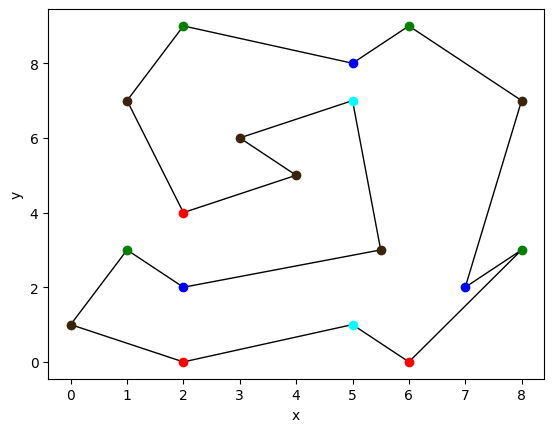

In [45]:
colors = color_vertex(polygon)
draw_polygon_colors(polygon, colors)

***

# Triangulacja wielokąta monotonicznego

Triangulacja wielokąta monotonicznego to proces podziału wielokąta monotonicznego na trójkąty poprzez dodawanie przekątnych (linii łączących wierzchołki), które nie przecinają się wewnętrznie.

### Przykładowy wielokąt podzielony na trójkąty.

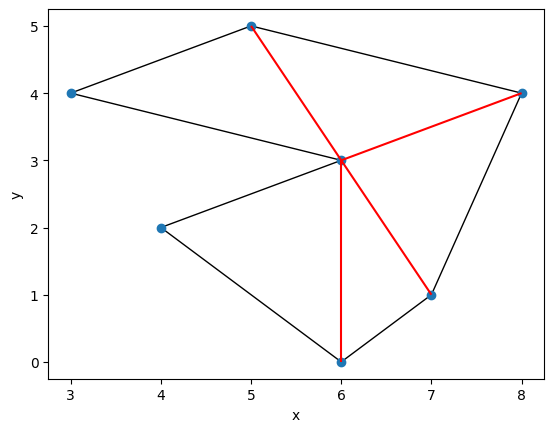

In [46]:
draw_polygon_tri(polygon_example_1, polygon_example_tri)

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```triangulation```. Wykorzystaj algorytm opisany na wykładzie.

In [47]:
def onLeftSideOfPolygon(polygon):
    n = len(polygon)
    result = [False for _ in range(n)]
    p = find_index_of_highest(polygon)
    p = nextNbour(p, n)
    last = find_index_of_highest(polygon, reversed=True)
    while p != last:
        result[p] = True
        p = nextNbour(p, n)

    return result

In [48]:
import bisect
import operator
from collections import namedtuple


class Edge:
    def __init__(self, a, b, helperIdx=None) -> None:
        self.diag = sorted([a, b])
        self.helperIdx = helperIdx
        self.__orderKey = self.firstToRight(0)

    def firstToRight(self, key=0):
        func = min if key == 0 else max
        return self.__closestCoordinate(func, key)

    def firstToLeft(self, key=0):
        func = max if key == 0 else min
        return self.__closestCoordinate(func, key)

    def __closestCoordinate(self, func, key):
        return func(self.diag, key=lambda x: x[key])[key]

    def __eq__(self, other) -> bool:
        return type(self) == type(other) and self.diag == other.diag

    def __lt__(self, other):
        return self.__orderKey < other.__orderKey

    def __gt__(self, other):
        return self.__orderKey > other.__orderKey


class TriBST:

    def __init__(self, polygon, pointsColors, LABELS_COLORS=dict((v, k) for (k, v) in COLORS_LABELS.items())) -> None:
        self.tree = []
        self.polygon = polygon
        self.pointsColors = pointsColors
        self.labels = LABELS_COLORS

    def insertEdge(self, edge: Edge):
        bisect.insort(self.tree, edge)

    def getEdgeHelper(self, edge: Edge):
        if edge.helperIdx is not None:
            return edge.helperIdx
        edgeInState = self.__findEdge(edge)
        if edgeInState != None:
            return edgeInState.helperIdx

    def removeEdge(self, edge):
        i = self.__findEdgeIdx(edge)
        if i != None:
            self.tree.pop(i)
    EdgeQuery = namedtuple("EdgeQuery", ["func", "operator", "coordinate"])

    def createLeftEdge(self, point_idx, helper_idx=None):
        return self.__createEdge(point_idx, self.EdgeQuery(min, operator.le, 0), helper_idx=helper_idx)

    def createRightEdge(self, point_idx, helper_idx=None):
        return self.__createEdge(point_idx, self.EdgeQuery(max, operator.ge, 0), helper_idx=helper_idx)

    def createHigherEdge(self, point_idx, helper_idx=None):
        return self.__createEdge(point_idx, self.EdgeQuery(max, operator.ge, 1), helper_idx=helper_idx)

    def createLowerEdge(self, point_idx, helper_idx=None):
        return self.__createEdge(point_idx, self.EdgeQuery(min, operator.le, 1), helper_idx=helper_idx)

    def __createEdge(self, point_idx, params: EdgeQuery, helper_idx=None):
        polygon = self.polygon
        n = len(polygon)
        coordinate = params.coordinate
        secondCoordinate = 1-coordinate
        relate = params.operator
        func = params.func
        help_func = max if func.__name__ == "min" else min
        candidates = [polygon[prevNbour(point_idx, n)],
                      polygon[nextNbour(point_idx, n)]]
        # if both candidates are on the same side of the point - we return higher/lower edge
        if relate(help_func(candidates, key=lambda x: x[coordinate])[coordinate], polygon[point_idx][coordinate]):
            return Edge(polygon[point_idx], help_func(candidates, key=lambda x: x[secondCoordinate]), helper_idx)
        return Edge(polygon[point_idx], func(candidates, key=lambda x: x[coordinate]), helper_idx)

    def getPointLabel(self, point_idx):
        if point_idx == None:
            return None
        return self.labels[self.pointsColors[point_idx]]

    def __findFirstLeftEdgeFromX(self, x) -> Edge:
        i = bisect.bisect(self.tree, x, key=lambda x: x.firstToLeft(0))
        if i != 0:
            return i-1

    def __findEdgeIdx(self, edge: Edge) -> int:
        i = bisect.bisect(self.tree, edge)
        if i < len(self.tree) and self.tree[i] == edge:
            return i
        if i > 0 and self.tree[i-1] == edge:
            return i-1

    def __findEdge(self, edge: Edge) -> Edge:
        i = self.__findEdgeIdx(edge)
        if i != None:
            return self.tree[i]

    def findFirstToTheLeft(self, point_idx):
        while len(self.tree) > 0:
            found_idx = self.__findFirstLeftEdgeFromX(
                self.polygon[point_idx][0])
            found = self.tree[found_idx]
            if found.firstToLeft(1) < self.polygon[point_idx][1]:
                return found
            self.tree.pop(found_idx)

In [49]:
def divideToMonotonicPolygons(polygon, colors=COLORS_LABELS):
    labels = dict((v, k) for k, v in colors.items())
    n = len(polygon)
    colors = color_vertex(polygon)

    isPointOnLeft = onLeftSideOfPolygon(polygon)
    # Struktura zdarzeń
    PointsOrder = [i for i in range(n)]
    PointsOrder = sorted(
        PointsOrder, key=lambda x: (-polygon[x][1], polygon[x][0]))

    # Struktura stanu
    BSC = TriBST(polygon, colors)  # BroomStateController

    newDiagonals = []

    for v in PointsOrder:
        currentLabel = BSC.getPointLabel(v)
        if currentLabel == START:
            leftEdge = BSC.createLeftEdge(v, v)
            BSC.insertEdge(leftEdge)

        elif currentLabel == END:
            leftEdge = BSC.createLeftEdge(v)
            helperIdx = BSC.getEdgeHelper(leftEdge)
            if BSC.getPointLabel(helperIdx) == CONNECT:
                new = (v, helperIdx)
                newDiagonals.append(new)
            BSC.removeEdge(leftEdge)

        elif currentLabel == DIVIDE:
            leftEdgeFromBroom = BSC.findFirstToTheLeft(v)  # ev
            helperIdx = BSC.getEdgeHelper(leftEdgeFromBroom)
            new = (v, helperIdx)
            newDiagonals.append(new)
            leftEdgeFromBroom.helperIdx = v
            rightEdge = BSC.createRightEdge(v, v)
            BSC.insertEdge(rightEdge)

        elif currentLabel == CONNECT:
            rightEdge = BSC.createRightEdge(v)
            helperIdx = BSC.getEdgeHelper(rightEdge)
            if labels[colors[helperIdx]] == CONNECT:
                new = (v, helperIdx)
                newDiagonals.append(new)
            BSC.removeEdge(rightEdge)
            leftEdgeFromBroom = BSC.findFirstToTheLeft(v)
            helperIdx = BSC.getEdgeHelper(leftEdgeFromBroom)
            if BSC.getPointLabel(helperIdx) == CONNECT:
                new = (v, helperIdx)
                newDiagonals.append(new)
            leftEdgeFromBroom.helperIdx = v

        elif currentLabel == REGULAR:
            if isPointOnLeft[v]:
                higherEdge = BSC.createHigherEdge(v)
                helperIdx = BSC.getEdgeHelper(higherEdge)
                if helperIdx != None:
                    if BSC.getPointLabel(helperIdx) == CONNECT:
                        new = (v, helperIdx)
                        newDiagonals.append(new)
                    BSC.removeEdge(higherEdge)
                new = BSC.createLowerEdge(v, v)
                BSC.insertEdge(new)
            else:
                leftEdgeFromBroom = BSC.findFirstToTheLeft(v)
                helperIdx = BSC.getEdgeHelper(leftEdgeFromBroom)
                if BSC.getPointLabel(helperIdx) == CONNECT:
                    new = (v, helperIdx)
                    newDiagonals.append(new)
                leftEdgeFromBroom.helperIdx = v

    return newDiagonals

In [50]:
newDiag = divideToMonotonicPolygons(polygon_example_2)
vis = Visualizer()
vis.add_polygon(polygon_example_2, fill=False)
for diag in newDiag:
    vis.add_line_segment(diag, color='red')
vis.show()

TypeError: 'key' is an invalid keyword argument for bisect_right()

In [ ]:
def triangulation(polygon):
    """
    Funkcja dokonuje triangulacji wielokąta monotonicznego. 
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica krotek dodawanych po kolei przekątnych np: [(1,5),(2,3)], oznacza, że triangulacja polega na dodaniu przekątnej pomiędzy wierzchołki 1-5 i 2-3
    """
    n = len(polygon)
    colors = color_vertex(polygon)

    # Struktura zdarzeń
    Q = [i for i in range(n)]
    Q = sorted(Q, key=lambda x: -polygon[x][1])

    # Struktura stanu

Jakich struktur można użyć do przechowywania wielokątu, oraz utworzonej triangulacji? Uzasadnij wybór struktury w swoim algorytmie

ODPOWIEDŹ: 

Przeprowadź testy poprawności powyższej funkcji.


In [ ]:
Test().runtest(3, triangulation)

Zwizualizuj powstały wielokąt podzielony na trójkąty.

In [ ]:
tri = triangulation(polygon)
draw_polygon_tri(polygon, tri)